# Detect subclusters for Phylogroup P3

In [16]:
import pandas as pd
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

#import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np
import networkx as nx
import plotly.graph_objects as go
import yaml
import matplotlib.patches as mpatches
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib.patches import Rectangle

sns.set_context("paper")

In [17]:
with open("config.yaml", "r") as f:
    notebook_configuration = yaml.safe_load(f)
notebook_configuration

{'bgcflow_dir': '/datadrive/bgcflow'}

In [18]:
# Write samples.csv table to config directory of qc_strepto_ncbi project
bgcflow_dir = Path(notebook_configuration["bgcflow_dir"])
project_name_1 = "mq_strepto"
processed_dir_1 = bgcflow_dir / "data" / "processed" / project_name_1

# Read output tables from the processed directory
ncbi_meta_table = processed_dir_1 / "tables"/ "df_ncbi_meta.csv"
df_ncbi_meta = pd.read_csv(ncbi_meta_table, index_col= 0)

gtdb_meta_table = processed_dir_1 / "tables"/ "df_gtdb_meta_curated.csv"
df_gtdb_meta = pd.read_csv(gtdb_meta_table, index_col= 0)

seqfu_meta_table = processed_dir_1 / "tables"/ "df_seqfu_stats.csv"
df_seqfu_meta = pd.read_csv(seqfu_meta_table, index_col= 0)

mash_table = processed_dir_1 / "mash"/ "df_mash.csv"
df_mash = pd.read_csv(mash_table, index_col= 0)

filters_table = processed_dir_1 / "tables" / "df_filters.csv"
df_filter_quality = pd.read_csv(filters_table, index_col=0)

In [19]:
df_mash_original = df_mash.copy()

In [20]:
df_clusters = pd.read_csv("assets/tables/df_mash_clusters_main.csv", index_col=0)
df_clusters_filtered = pd.read_csv("assets/tables/df_mash_clusters_main_reduced.csv", index_col=0)
df_clusters["phylogroup"] = "NA"
df_clusters["phylogroup_color"] = "#808080"
df_clusters.loc[df_clusters_filtered.index, "phylogroup"] = ["P" + str(cluster_id) for cluster_id in df_clusters_filtered.Cluster]
df_clusters.loc[df_clusters_filtered.index, "phylogroup_color"] = df_clusters_filtered.Cluster_Color

# Subclustering for phylogroup P3

In [21]:
df_clusters_selected_phylogroup = df_clusters[df_clusters.phylogroup == "P3"]

In [22]:
def kMeansRes(scaled_data, k, alpha_k=0.02):
    '''
    # Calculating clusters from https://medium.com/towards-data-science/an-approach-for-choosing-number-of-clusters-for-k-means-c28e614ecb2c
    Parameters 
    ----------
    scaled_data: matrix 
        scaled data. rows are samples and columns are features for clustering
    k: int
        current k for applying KMeans
    alpha_k: float
        manually tuned factor that gives penalty to the number of clusters
    Returns 
    -------
    scaled_inertia: float
        scaled inertia value for current k           
    '''
    
    inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
    # fit k-means
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia

def chooseBestKforKMeans(scaled_data, k_range):
    ans = []
    for k in k_range:
        scaled_inertia = kMeansRes(scaled_data, k)
        ans.append((k, scaled_inertia))
    results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
    best_k = results.idxmin()[0]
    return best_k, results

## Perform heirarchical clustering

1. Convert distance matrix to similarity
2. Compute pairwise distances using Pearson's correlation coefficient to be used as feature tables
3. Performing hierarchical clustering using ward.D2 method to get linkage matrix

In [23]:
# Subtracting Mash distances from 1 to convert to similarity
df_mash = df_mash_original.loc[df_clusters_selected_phylogroup.index, df_clusters_selected_phylogroup.index]
df_similarity = 1 - df_mash

# Computing pairwise distances using Pearson's correlation coefficient
distances = squareform(pdist(df_similarity, metric='correlation'))

# Performing hierarchical clustering using ward.D2 method
linkage_matrix = linkage(distances, method='ward')

# Reordering rows and columns of the distance matrix based on clustering
ordered_indices = dendrogram(linkage_matrix, no_plot=True)['leaves']
df_reordered = df_similarity.iloc[ordered_indices, ordered_indices]

## Plot the K-means adjusted intertia plot

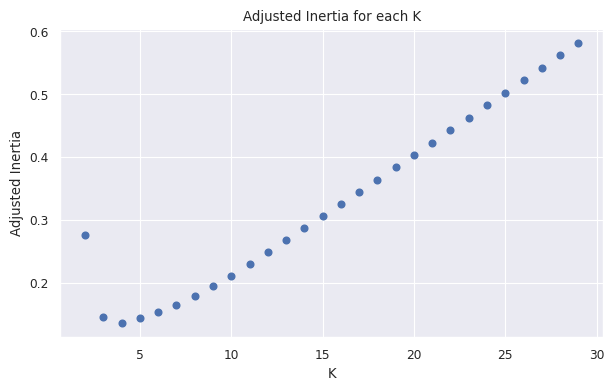

In [24]:
# choose k range
max_range = 30

k_range=range(2, max_range)
# compute adjusted intertia
best_k, results = chooseBestKforKMeans(distances, k_range)

# plot the results
plt.figure(figsize=(7,4))
plt.plot(results,'o')
plt.title('Adjusted Inertia for each K')
plt.xlabel('K')
plt.ylabel('Adjusted Inertia')
plt.savefig("assets/figures/Figure_P3/kmeans_plot.png")
plt.show()

## Plot sum of Silhoutte score to find optimal clustering at global scale

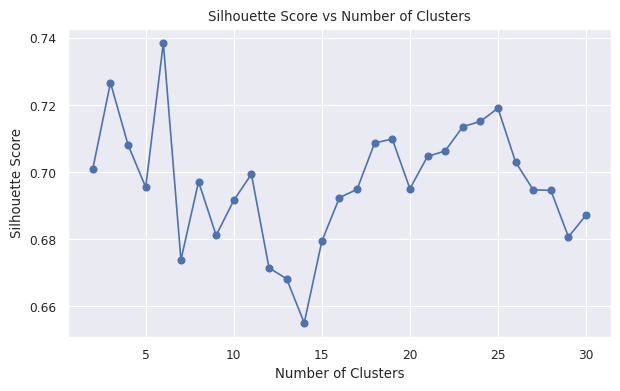

In [25]:
# Define a range of possible numbers of clusters
min_clusters = 2
max_clusters = 30

# Variables to store the silhouette scores
silhouette_scores = []

# Iterate over different numbers of clusters
for num_clusters in range(min_clusters, max_clusters+1):
    # Use fcluster to assign cluster labels
    clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

    # Calculate the silhouette score
    score = silhouette_score(distances, clusters)
    
    # Store the silhouette score
    silhouette_scores.append(score)

silhouette_scores_prefiltering = silhouette_scores.copy()

# Plot the silhouette scores against the number of clusters
plt.figure(figsize=(7,4))
plt.plot(range(min_clusters, max_clusters+1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.savefig("assets/figures/Figure_P3/silhouette_maxima_plot.png")
plt.show()

## Pick the best clusters

In [26]:
n_clusters = 6

## Get cluster assignments

In [27]:
# Use fcluster to assign cluster labels
clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

# Create dataframe assigning genomes to clusters
df_mash_clusters_kmeans = pd.DataFrame({'Cluster': clusters}, index=df_similarity.index)

# Define the colors for 15 detected clusters
color_set_15 = ["#e6194b", "#3cb44b", "#ffe119", "#0082c8", "#f58231", "#911eb4", "#46f0f0", "#f032e6", "#d2f53c", "#fabebe", "#008080", "#e6beff", "#aa6e28", "#fffac8", "#800000"]
cluster_list = sorted(df_mash_clusters_kmeans.Cluster.unique())
cluster_color_dict = dict(zip(cluster_list, color_set_15[:len(cluster_list)]))

# Update df_mash_clusters
df_mash_clusters_kmeans["Cluster_Color"] = [cluster_color_dict[df_mash_clusters_kmeans.loc[genome_id, "Cluster"]] for genome_id in df_mash_clusters_kmeans.index]
df_mash_clusters_kmeans["Species"] = df_gtdb_meta.loc[df_mash_clusters_kmeans.index,"Species"]
df_mash_clusters_kmeans = df_mash_clusters_kmeans.loc[df_reordered.index, :]

df_mash_clusters_kmeans.to_csv("assets/tables/df_subclusters_P3.csv")

## Plot clustermap with all genomes

In [28]:
df_clusters_selected_phylogroup.Species.value_counts()

Species
sp.                   89
anulatus              58
bacillaris            33
sp003846175           26
papulosus             24
californicus          24
parvus                20
microflavus           18
silvae                14
cyaneofuscatus        14
globisporus           12
griseus               12
fimicarius            12
sp001905735           11
sp900116325           11
rubiginosohelvolus    11
sp900105515           10
halstedii             10
sp000177195            9
sp001905365            8
poriferorum            6
clavifer               6
sp940670765            5
sp003116725            5
laculatispora          5
sp008042155            4
sp008042035            3
sp003248355            3
brevispora             3
sp001905125            3
atratus_B              3
sindenensis            3
globisporus_A          2
sp001905505            2
atratus                2
fulvorobeus            2
sp001905595            2
sp001895105            2
sp001905905            2
nitrosporeus     

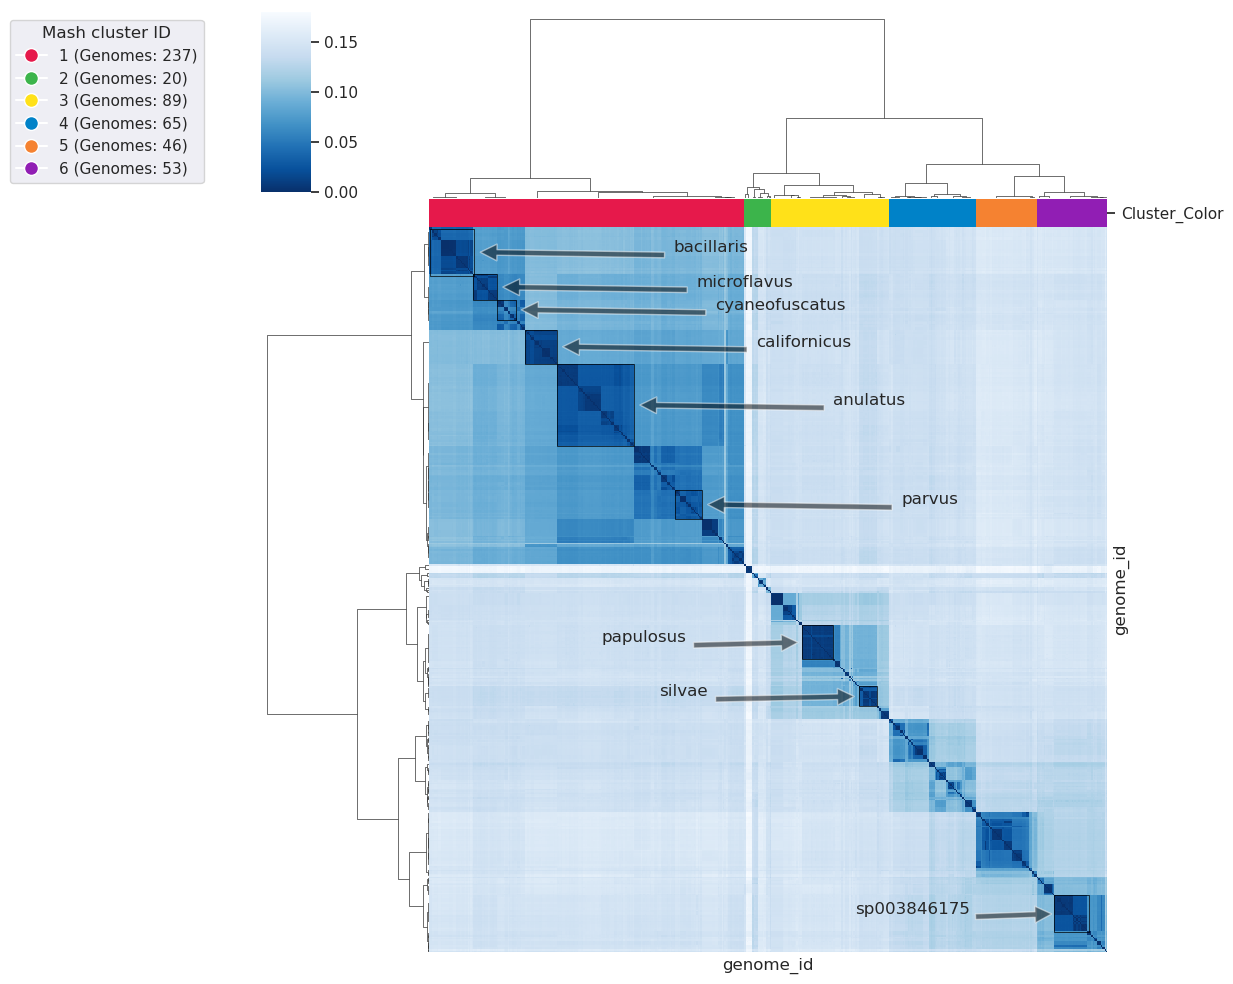

In [29]:
# Plotting the clustermap below the dendrogram
col_colors = df_mash_clusters_kmeans["Cluster_Color"]
sns.set(font_scale=1.0)  # Adjust font size for row labels
g = sns.clustermap(df_mash, cmap='Blues_r', 
                   row_linkage=linkage_matrix, col_linkage=linkage_matrix, 
                   col_colors= col_colors,
                   xticklabels=False, yticklabels=False)

# Create a color legend with unique cluster colors
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_color_dict[cluster],
                           markersize=10) for cluster in sorted(cluster_list)]

cluster_sizes = df_mash_clusters_kmeans.Cluster.value_counts()
labels = [f"{cluster} (Genomes: {cluster_sizes[cluster]})" for cluster in sorted(cluster_list)]

# Add color legend
plt.legend(color_legend, labels, title='Mash cluster ID', bbox_to_anchor=(-1, 1))

# Highlight particular species
species_list = ["anulatus", "bacillaris", "sp003846175", "papulosus", "californicus", 
                "parvus", "microflavus", "silvae", "cyaneofuscatus"]

for selected_species in species_list:
    x_min = 0 
    y_min = 0 
    xy_size = 0
    
    for idx in range(df_mash_clusters_kmeans.shape[0]):
        if selected_species == df_mash_clusters_kmeans.iloc[idx, 2]:
            xy_size = xy_size + 1
            if x_min == 0:
                x_min = idx
                y_min = idx      
    
    highlight = Rectangle((x_min, y_min), xy_size, xy_size, fill=False, edgecolor='black', lw=0.5)  # square with lower-left corner at (0,0), width and height 2
    g.ax_heatmap.add_patch(highlight)
    g.ax_heatmap.plot()  # Refresh the plot
    
    # Adding text label
    if x_min > 250:
        g.ax_heatmap.annotate(selected_species, xy=(x_min, y_min+xy_size/2), xytext=(x_min-150, y_min+xy_size/2),
                     arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))
    else:
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+150, y_min+xy_size/2),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))

plt.savefig("assets/figures/Figure_P3/mash_clustermap_P3.png", bbox_inches="tight")
plt.show()

## Silhouette coefficient assessment

Assess the above clustering using the silhouette coefficient for each of the detected clusters

In [30]:
n_clusters = 6

# cluster_mapping_dict = {1:2, 2:3, 3:6, 4:7, 5:5, 6:4, 7:1}

color_map = {'1': '#e6194b',
 '2': '#3cb44b',
 '3': '#ffe119',
 '4': '#0082c8',
 '5': '#f58231',
 '6': '#911eb4'}

# Select samples above a threshold
threshold = 0.4

In [31]:
# Subtracting Mash distances from 1 to convert to similarity
df_mash = df_mash_original.loc[df_clusters_selected_phylogroup.index, df_clusters_selected_phylogroup.index]
df_similarity = 1 - df_mash

# Computing pairwise distances using Pearson's correlation coefficient
distances = squareform(pdist(df_similarity, metric='correlation'))

# Performing hierarchical clustering using ward.D2 method
linkage_matrix = linkage(distances, method='ward')

# Reordering rows and columns of the distance matrix based on clustering
ordered_indices = dendrogram(linkage_matrix, no_plot=True)['leaves']
df_reordered = df_similarity.iloc[ordered_indices, ordered_indices]


# Use fcluster to assign cluster labels
clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

# Compute silhouette coefficient for each sample
silhouette_values = silhouette_samples(distances, clusters)

df_silhouette = pd.DataFrame({"Cluster": clusters, "Silhouette": silhouette_values}, index=df_similarity.index)
df_silhouette.to_csv("assets/tables/df_silhouette_P3.csv")

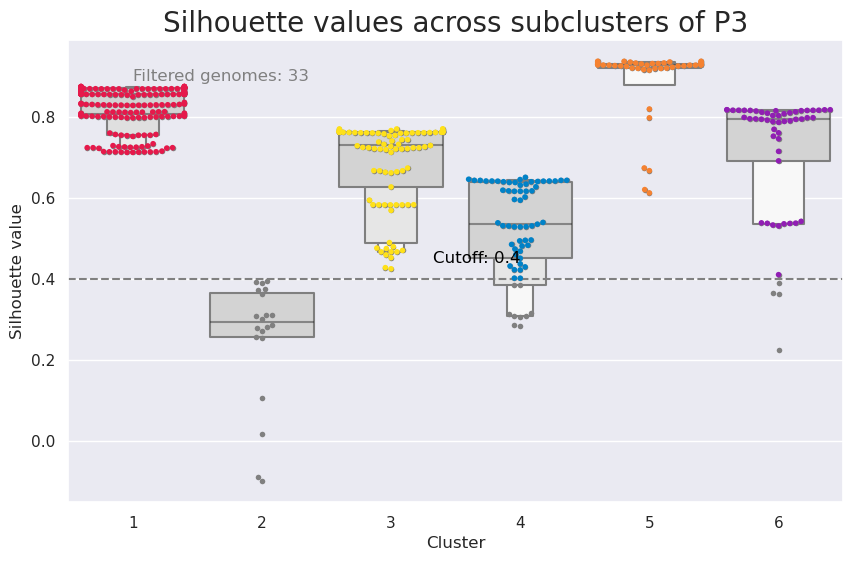

In [32]:
# Select samples above a threshold
data = df_silhouette.copy()
filtered_data = data[data["Silhouette"] >= threshold]

# Create the boxenplot using the filtered data
plt.figure(figsize=(10, 6))
sns.boxenplot(x='Cluster', y='Silhouette', data=data, color='lightgray', showfliers=False)
sns.swarmplot(x='Cluster', y='Silhouette', data=data, size=4, color="grey")
sns.swarmplot(x='Cluster', y='Silhouette', data=filtered_data, size=4, palette=color_map)
plt.axhline(y=threshold, color='gray', linestyle='--', label='Cutoff Value')
plt.text(3, threshold + 0.05, f'Cutoff: {threshold}', color='black', ha='right', va='center')
plt.text(0, 0.9, f'Filtered genomes: {data.shape[0] - filtered_data.shape[0]}', color='grey', ha='left', va='center')

plt.title('Silhouette values across subclusters of P3', fontdict={"size": 20})
plt.xlabel('Cluster')
plt.ylabel('Silhouette value')

# Show the plot
plt.savefig("assets/figures/Figure_P3/silhouette_P3_1.png", bbox_inches="tight")
plt.show()

## Iterate the clustering step till 0.4 cutoff is reached for all genomes

In [33]:
cluster_mapping_dict = {1:1, 2:3, 3:4, 4:5, 5:6}
n_clusters = 5

In [34]:
# Subtracting Mash distances from 1 to convert to similarity
df_mash = df_mash_original.loc[filtered_data.index, filtered_data.index]
df_similarity = 1 - df_mash

# Computing pairwise distances using Pearson's correlation coefficient
distances = squareform(pdist(df_similarity, metric='correlation'))

# Performing hierarchical clustering using ward.D2 method
linkage_matrix = linkage(distances, method='ward')

# Reordering rows and columns of the distance matrix based on clustering
ordered_indices = dendrogram(linkage_matrix, no_plot=True)['leaves']
df_reordered = df_similarity.iloc[ordered_indices, ordered_indices]

# Use fcluster to assign cluster labels
clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

# Compute silhouette coefficient for each sample
silhouette_values = silhouette_samples(distances, clusters)

clusters_updated = [cluster_mapping_dict[cluster_id] for cluster_id in clusters]
df_silhouette_filtered_2 = pd.DataFrame({"Cluster": clusters_updated, "Silhouette": silhouette_values}, index=df_similarity.index)
df_silhouette_filtered_2.to_csv("assets/tables/df_silhouette_P3_2.csv")

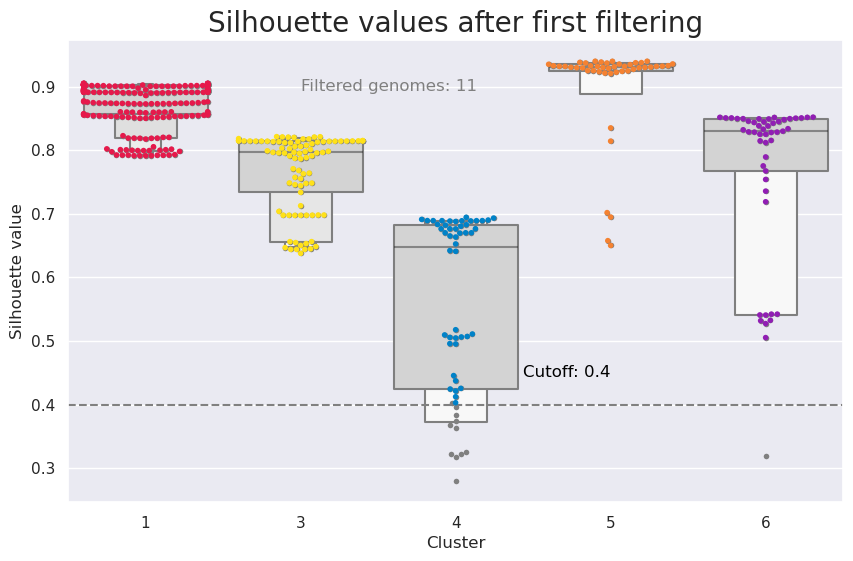

In [35]:
data = df_silhouette_filtered_2.copy()
filtered_data = data[data["Silhouette"] >= threshold]

# Create the boxenplot using the filtered data
plt.figure(figsize=(10, 6))
sns.boxenplot(x='Cluster', y='Silhouette', data=data, color='lightgray', showfliers=False)
sns.swarmplot(x='Cluster', y='Silhouette', data=data, size=4, color="grey")
sns.swarmplot(x='Cluster', y='Silhouette', data=filtered_data, size=4, palette=color_map)
plt.axhline(y=threshold, color='gray', linestyle='--', label='Cutoff Value')
plt.text(3, threshold + 0.05, f'Cutoff: {threshold}', color='black', ha='right', va='center')
plt.text(1, 0.9, f'Filtered genomes: {data.shape[0] - filtered_data.shape[0]}', color='grey', ha='left', va='center')

plt.title('Silhouette values after first filtering', fontdict={"size": 20})
plt.xlabel('Cluster')
plt.ylabel('Silhouette value')

# Show the plot
plt.savefig("assets/figures/Figure_P3/silhouette_P3_2.png", bbox_inches="tight")
plt.show()

In [36]:
# Subtracting Mash distances from 1 to convert to similarity
df_mash = df_mash_original.loc[filtered_data.index, filtered_data.index]
df_similarity = 1 - df_mash

# Computing pairwise distances using Pearson's correlation coefficient
distances = squareform(pdist(df_similarity, metric='correlation'))

# Performing hierarchical clustering using ward.D2 method
linkage_matrix = linkage(distances, method='ward')

# Reordering rows and columns of the distance matrix based on clustering
ordered_indices = dendrogram(linkage_matrix, no_plot=True)['leaves']
df_reordered = df_similarity.iloc[ordered_indices, ordered_indices]

# Use fcluster to assign cluster labels
clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

# Compute silhouette coefficient for each sample
silhouette_values = silhouette_samples(distances, clusters)

clusters_updated = [cluster_mapping_dict[cluster_id] for cluster_id in clusters]
df_silhouette_filtered_3 = pd.DataFrame({"Cluster": clusters_updated, "Silhouette": silhouette_values}, index=df_similarity.index)
df_silhouette_filtered_3.to_csv("assets/tables/df_silhouette_P3_3.csv")

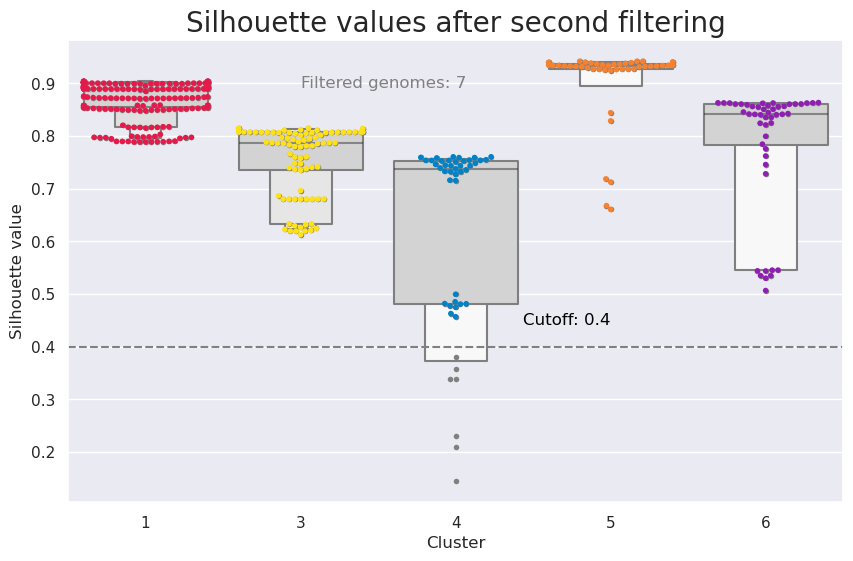

In [37]:
data = df_silhouette_filtered_3.copy()
filtered_data = data[data["Silhouette"] >= threshold]

# Create the boxenplot using the filtered data
plt.figure(figsize=(10, 6))
sns.boxenplot(x='Cluster', y='Silhouette', data=data, color='lightgray', showfliers=False)
sns.swarmplot(x='Cluster', y='Silhouette', data=data, size=4, color="grey")
sns.swarmplot(x='Cluster', y='Silhouette', data=filtered_data, size=4, palette=color_map)
plt.axhline(y=threshold, color='gray', linestyle='--', label='Cutoff Value')
plt.text(3, threshold + 0.05, f'Cutoff: {threshold}', color='black', ha='right', va='center')
plt.text(1, 0.9, f'Filtered genomes: {data.shape[0] - filtered_data.shape[0]}', color='grey', ha='left', va='center')

plt.title('Silhouette values after second filtering', fontdict={"size": 20})
plt.xlabel('Cluster')
plt.ylabel('Silhouette value')

# Show the plot
plt.savefig("assets/figures/Figure_P3/silhouette_P3_3.png", bbox_inches="tight")
plt.show()

### Plot Silhouette averages before and after removing noise

In [38]:
# Subtracting Mash distances from 1 to convert to similarity
df_mash = df_mash_original.loc[df_silhouette_filtered_3.index, df_silhouette_filtered_3.index]
df_similarity = 1 - df_mash

# Computing pairwise distances using Pearson's correlation coefficient
distances = squareform(pdist(df_similarity, metric='correlation'))

# Performing hierarchical clustering using ward.D2 method
linkage_matrix = linkage(distances, method='ward')

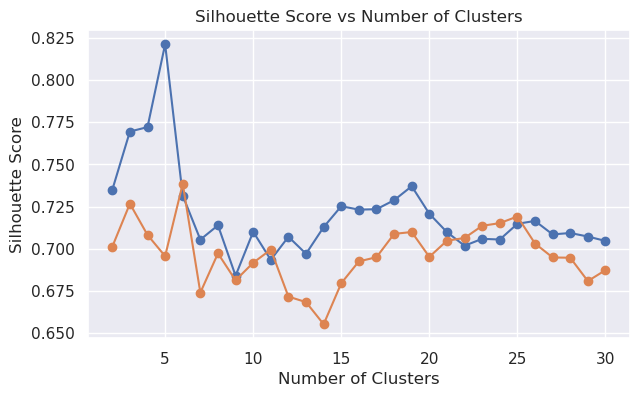

In [39]:
# Define a range of possible numbers of clusters
min_clusters = 2
max_clusters = 30

# Variables to store the silhouette scores
silhouette_scores = []

# Iterate over different numbers of clusters
for num_clusters in range(min_clusters, max_clusters+1):
    # Use fcluster to assign cluster labels
    clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

    # Calculate the silhouette score
    score = silhouette_score(distances, clusters)
    
    # Store the silhouette score
    silhouette_scores.append(score)

# Plot the silhouette scores against the number of clusters
plt.figure(figsize=(7,4))
plt.plot(range(min_clusters, max_clusters+1), silhouette_scores, marker='o')
plt.plot(range(min_clusters, max_clusters+1), silhouette_scores_prefiltering, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.savefig("assets/figures/Figure_P3/silhouette_maxima_comparison.png")
plt.show()

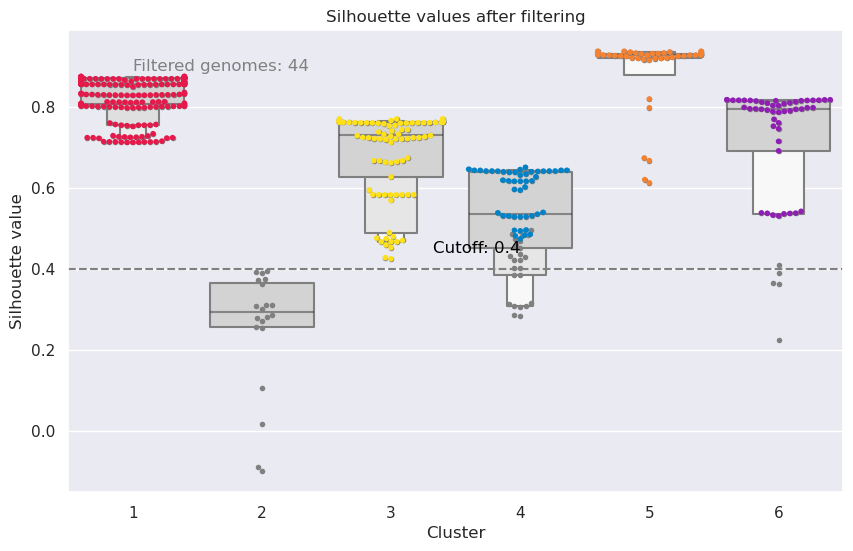

In [40]:
# Select samples above a threshold
data = df_silhouette.copy()
filtered_data = df_silhouette.loc[df_silhouette_filtered_3.index, :]

# Create the boxenplot using the filtered data
plt.figure(figsize=(10, 6))
sns.boxenplot(x='Cluster', y='Silhouette', data=data, color='lightgray', showfliers=False)
sns.swarmplot(x='Cluster', y='Silhouette', data=data, size=4, color="grey")
sns.swarmplot(x='Cluster', y='Silhouette', data=filtered_data, size=4, palette=color_map)
plt.axhline(y=threshold, color='gray', linestyle='--', label='Cutoff Value')
plt.text(3, threshold + 0.05, f'Cutoff: {threshold}', color='black', ha='right', va='center')
plt.text(0, 0.9, f'Filtered genomes: {data.shape[0] - filtered_data.shape[0]}', color='grey', ha='left', va='center')

plt.title('Silhouette values after filtering')
plt.xlabel('Cluster')
plt.ylabel('Silhouette value')

# Show the plot
plt.savefig("assets/figures/Figure_P3/silhouette_filter_comparison.png")
plt.show()

# 2. Reduced dataset by filtering wrongly clustered samples

In [41]:
# Subtracting Mash distances from 1 to convert to similarity
df_mash = df_mash_original.loc[df_clusters_selected_phylogroup.index, df_clusters_selected_phylogroup.index]
df_similarity = 1 - df_mash

# Computing pairwise distances using Pearson's correlation coefficient
distances = squareform(pdist(df_similarity, metric='correlation'))

# Performing hierarchical clustering using ward.D2 method
linkage_matrix = linkage(distances, method='ward')

# Reordering rows and columns of the distance matrix based on clustering
ordered_indices = dendrogram(linkage_matrix, no_plot=True)['leaves']
df_reordered = df_similarity.iloc[ordered_indices, ordered_indices]

In [42]:
n_clusters = 6

## Get cluster assignments

In [43]:
# Use fcluster to assign cluster labels
clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

# Create dataframe assigning genomes to clusters
df_mash_clusters_kmeans = pd.DataFrame({'Cluster': clusters}, index=df_similarity.index)

# Update df_mash_clusters
df_mash_clusters_kmeans["Cluster_Color"] = [cluster_color_dict[df_mash_clusters_kmeans.loc[genome_id, "Cluster"]] for genome_id in df_mash_clusters_kmeans.index]
df_mash_clusters_kmeans["Species"] = df_gtdb_meta.loc[df_mash_clusters_kmeans.index,"Species"]
df_mash_clusters_kmeans = df_mash_clusters_kmeans.loc[df_reordered.index, :]

## Plot clustermap with all genomes

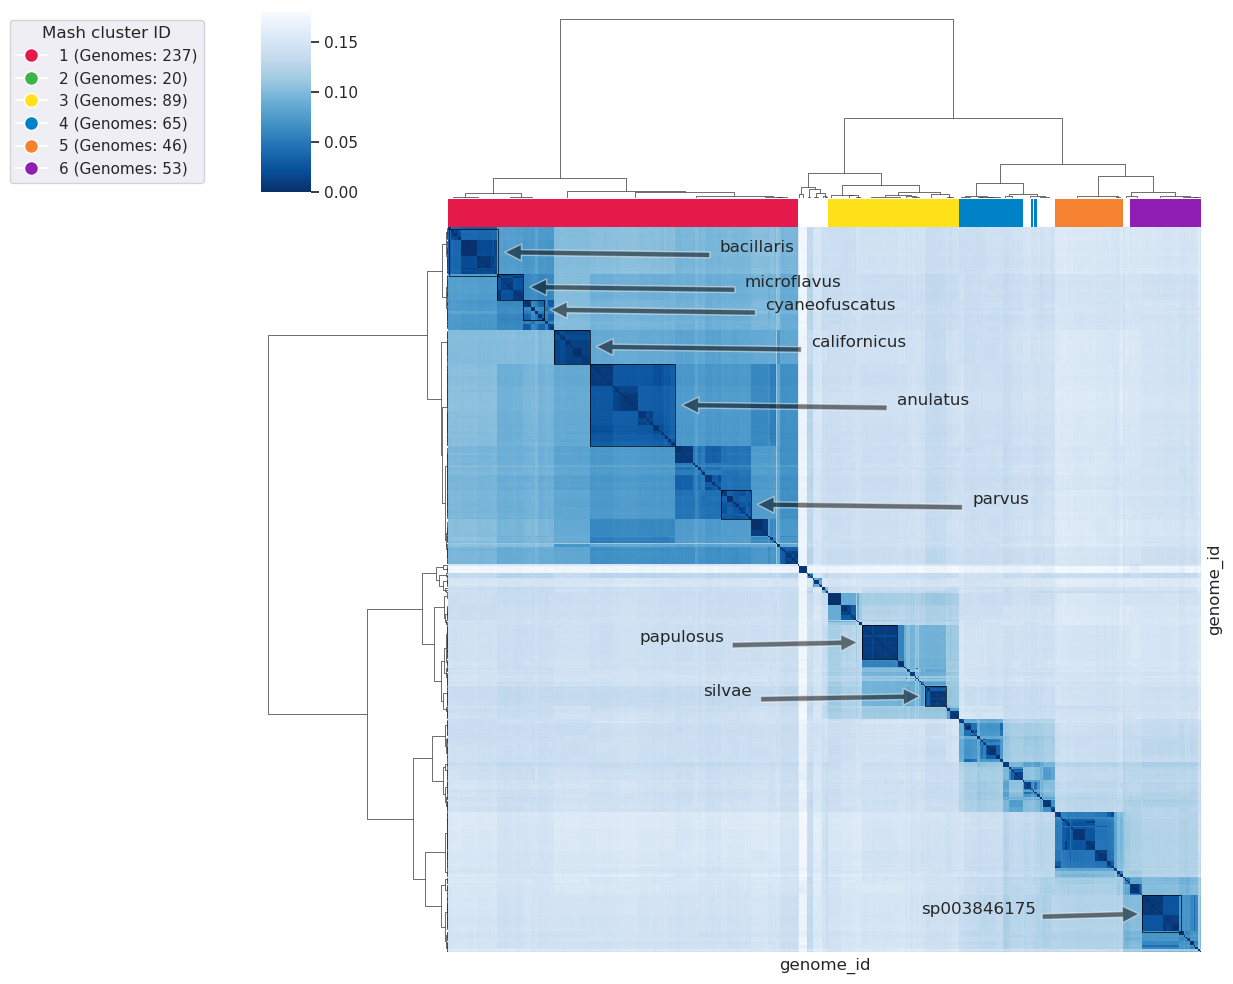

In [44]:
# Plotting the clustermap below the dendrogram
col_colors = [df_mash_clusters_kmeans.loc[genome_id, "Cluster_Color"] if genome_id in filtered_data.index.tolist() else "white" for genome_id in df_mash.index]

sns.set(font_scale=1.0)  # Adjust font size for row labels
g = sns.clustermap(df_mash, cmap='Blues_r', 
                   row_linkage=linkage_matrix, col_linkage=linkage_matrix, 
                   col_colors= col_colors,
                   xticklabels=False, yticklabels=False)

# Create a color legend with unique cluster colors
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_color_dict[cluster],
                           markersize=10) for cluster in sorted(cluster_list)]

cluster_sizes = df_mash_clusters_kmeans.Cluster.value_counts()
labels = [f"{cluster} (Genomes: {cluster_sizes[cluster]})" for cluster in sorted(cluster_list)]

# Add color legend
plt.legend(color_legend, labels, title='Mash cluster ID', bbox_to_anchor=(-1, 1))


# Highlight particular species
species_list = ["anulatus", "bacillaris", "sp003846175", "papulosus", "californicus", 
                "parvus", "microflavus", "silvae", "cyaneofuscatus"]

for selected_species in species_list:
    x_min = 0 
    y_min = 0 
    xy_size = 0
    
    for idx in range(df_mash_clusters_kmeans.shape[0]):
        if selected_species == df_mash_clusters_kmeans.iloc[idx, 2]:
            xy_size = xy_size + 1
            if x_min == 0:
                x_min = idx
                y_min = idx      
    
    highlight = Rectangle((x_min, y_min), xy_size, xy_size, fill=False, edgecolor='black', lw=0.5)  # square with lower-left corner at (0,0), width and height 2
    g.ax_heatmap.add_patch(highlight)
    g.ax_heatmap.plot()  # Refresh the plot
    
    # Adding text label
    if x_min > 250:
        g.ax_heatmap.annotate(selected_species, xy=(x_min, y_min+xy_size/2), xytext=(x_min-150, y_min+xy_size/2),
                     arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))
    else:
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+150, y_min+xy_size/2),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))
        
plt.savefig("assets/figures/Figure_P3/mash_clustermap_P3_filtered_all.png")
plt.show()

# Recluster the reduced Mash matrix

## Perform heirarchical clustering

1. Convert distance matrix to similarity
2. Compute pairwise distances using Pearson's correlation coefficient to be used as feature tables
3. Performing hierarchical clustering using ward.D2 method to get linkage matrix

In [45]:
# Subtracting Mash distances from 1 to convert to similarity
df_mash = df_mash_original.loc[df_silhouette_filtered_3.index, df_silhouette_filtered_3.index]
df_similarity = 1 - df_mash

# Computing pairwise distances using Pearson's correlation coefficient
distances = squareform(pdist(df_similarity, metric='correlation'))

# Performing hierarchical clustering using ward.D2 method
linkage_matrix = linkage(distances, method='ward')

# Reordering rows and columns of the distance matrix based on clustering
ordered_indices = dendrogram(linkage_matrix, no_plot=True)['leaves']
df_reordered = df_similarity.iloc[ordered_indices, ordered_indices]

In [46]:
n_clusters = 5

## Get cluster assignments

In [47]:
# Use fcluster to assign cluster labels
clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

cluster_mapping_dict = {1:1, 2:3, 3:4, 4:5, 5:6}
# Create dataframe assigning genomes to clusters
df_mash_clusters_kmeans = pd.DataFrame({'Cluster': [cluster_mapping_dict[cluster_id] for cluster_id in clusters]}, index=df_similarity.index)

# Update df_mash_clusters
df_mash_clusters_kmeans["Cluster_Color"] = [cluster_color_dict[df_mash_clusters_kmeans.loc[genome_id, "Cluster"]] for genome_id in df_mash_clusters_kmeans.index]
df_mash_clusters_kmeans["Species"] = df_gtdb_meta.loc[df_mash_clusters_kmeans.index,"Species"]
df_mash_clusters_kmeans = df_mash_clusters_kmeans.loc[df_reordered.index, :]

df_mash_clusters_kmeans.to_csv("assets/tables/df_subclusters_P3_reduced.csv")

## Plot clustermap with all genomes

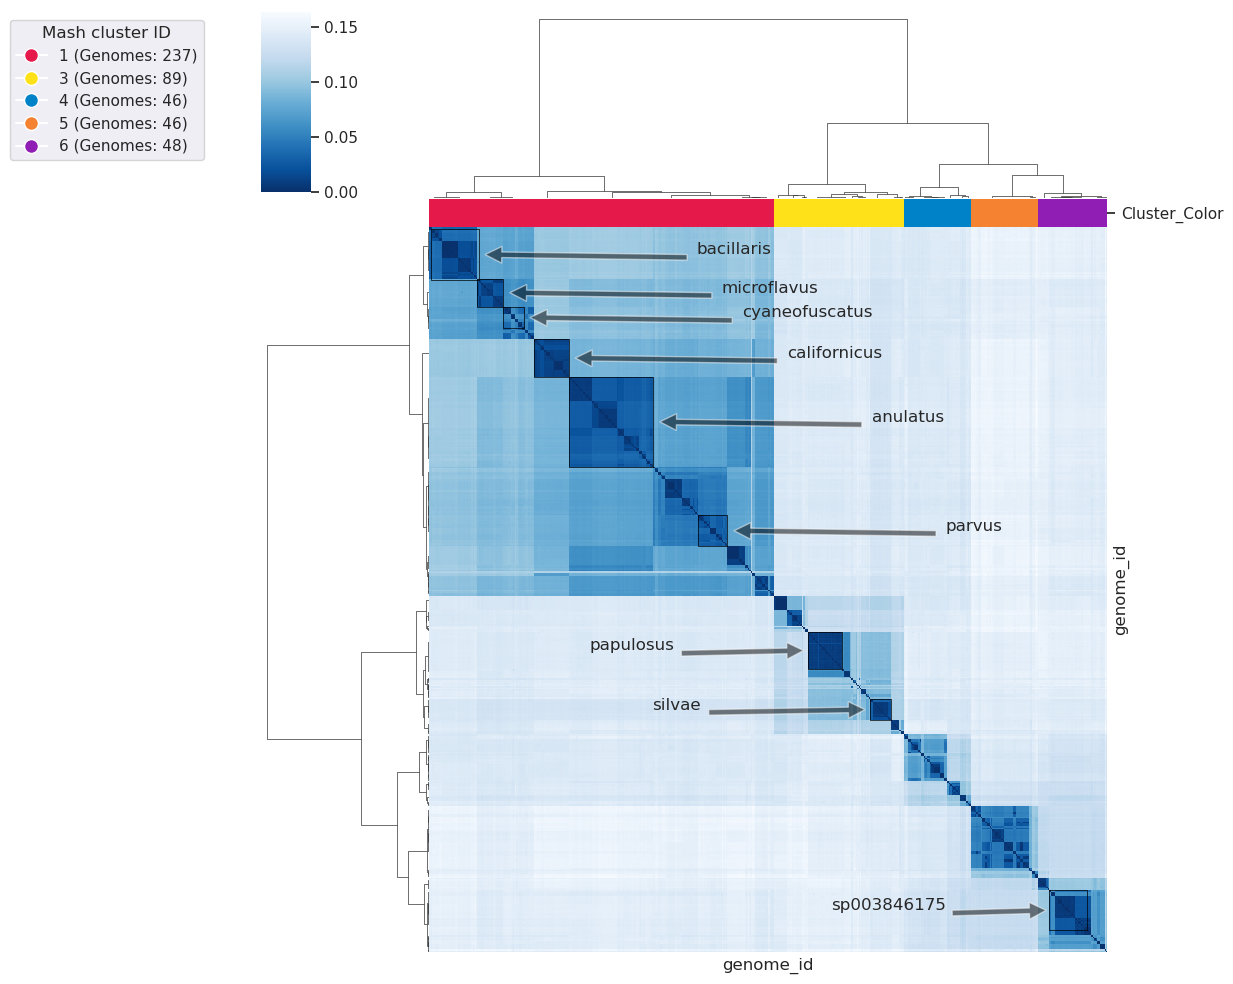

In [48]:
# Plotting the clustermap below the dendrogram
col_colors =df_mash_clusters_kmeans.loc[df_mash.index, "Cluster_Color"]
sns.set(font_scale=1.0)  # Adjust font size for row labels
g = sns.clustermap(df_mash, cmap='Blues_r', 
                   row_linkage=linkage_matrix, col_linkage=linkage_matrix, 
                   col_colors= col_colors,
                   xticklabels=False, yticklabels=False)

cluster_list = sorted(cluster_mapping_dict.values())
# Create a color legend with unique cluster colors
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_color_dict[cluster],
                           markersize=10) for cluster in sorted(cluster_list)]

cluster_sizes = df_mash_clusters_kmeans.Cluster.value_counts()
labels = [f"{cluster} (Genomes: {cluster_sizes[cluster]})" for cluster in sorted(cluster_list)]

# Add color legend
plt.legend(color_legend, labels, title='Mash cluster ID', bbox_to_anchor=(-1, 1))

# Highlight particular species
species_list = ["anulatus", "bacillaris", "sp003846175", "papulosus", "californicus", 
                "parvus", "microflavus", "silvae", "cyaneofuscatus"]

for selected_species in species_list:
    x_min = 0 
    y_min = 0 
    xy_size = 0
    
    for idx in range(df_mash_clusters_kmeans.shape[0]):
        if selected_species == df_mash_clusters_kmeans.iloc[idx, 2]:
            xy_size = xy_size + 1
            if x_min == 0:
                x_min = idx
                y_min = idx      
    
    highlight = Rectangle((x_min, y_min), xy_size, xy_size, fill=False, edgecolor='black', lw=0.5)  # square with lower-left corner at (0,0), width and height 2
    g.ax_heatmap.add_patch(highlight)
    g.ax_heatmap.plot()  # Refresh the plot
    
    # Adding text label
    if x_min > 250:
        g.ax_heatmap.annotate(selected_species, xy=(x_min, y_min+xy_size/2), xytext=(x_min-150, y_min+xy_size/2),
                     arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))
    else:
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+150, y_min+xy_size/2),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))

plt.savefig("assets/figures/Figure_P3/mash_clustermap_P3_reduced.png")
plt.show()

# Old codes

In [49]:
# cluster_list = sorted(df_mash_clusters_kmeans.Cluster.unique())

# df_mash_subclusters_dict = {}
# for cluster_id in cluster_list:
#     genomes_phylogroup = df_mash_clusters_kmeans[df_mash_clusters_kmeans.Cluster == cluster_id].index.tolist()
#     # Subtracting Mash distances from 1 to convert to similarity
#     df_mash_selected = df_mash_original.loc[genomes_phylogroup, genomes_phylogroup]
#     df_similarity_selected = 1 - df_mash_selected
    
#     # Computing pairwise distances using Pearson's correlation coefficient
#     distances_selected = squareform(pdist(df_similarity_selected, metric='correlation'))
    
#     # Performing hierarchical clustering using ward.D2 method
#     linkage_matrix_selected = linkage(distances_selected, method='ward')

#     # Reordering rows and columns of the distance matrix based on clustering
#     ordered_indices = dendrogram(linkage_matrix_selected, no_plot=True)['leaves']
#     df_reordered_selected = df_similarity_selected.iloc[ordered_indices, ordered_indices]
    
#     # choose k range
#     if len(df_mash_selected) <= 21:
#         max_range = len(df_mash_selected) - 1
#     else:
#         max_range = 20
    
#     k_range=range(2, max_range)
#     # compute adjusted intertia
#     best_k, results = chooseBestKforKMeans(distances_selected, k_range)
    
#     # plot the results
#     plt.figure(figsize=(7,4))
#     plt.plot(results,'o')
#     plt.title('Adjusted Inertia for each K')
#     plt.xlabel('K')
#     plt.ylabel('Adjusted Inertia')
#     plt.xticks(range(2,max_range,1))
#     print(f"Estimated number of clusters: {best_k}")
#     plt.savefig("assets/figures/Figure_2/kmeans_plot_" + str(cluster_id) + ".png")
#     plt.show()
    
#     # Cluster using best k-means
#     n_clusters = best_k
    
#     # max color 12
#     if best_k < 12:
#         top_clusters = best_k
#     else:
#         top_clusters = 12
    
#     # Use fcluster to assign cluster labels
#     clusters_selected = fcluster(linkage_matrix_selected, t=n_clusters, criterion='maxclust')
    
#     # Create dataframe assigning genomes to clusters
#     df_mash_clusters_kmeans_selected = pd.DataFrame({'Subcluster': clusters_selected}, index=df_similarity_selected.index)

#     # Define the colors for 15 detected clusters
#     color_set_15 = ["#e6194b", "#3cb44b", "#ffe119", "#0082c8", "#f58231", "#911eb4", "#46f0f0", "#f032e6", "#d2f53c", "#fabebe", "#008080", "#e6beff", "#aa6e28", "#fffac8", "#800000"]
#     subcluster_list = sorted(df_mash_clusters_kmeans_selected.Subcluster.unique())
#     subcluster_color_dict = dict(zip(subcluster_list, color_set_15[:len(subcluster_list)]))
    
#     # Update df_mash_clusters
#     df_mash_clusters_kmeans_selected["Subcluster_Color"] = [subcluster_color_dict[df_mash_clusters_kmeans_selected.loc[genome_id, "Subcluster"]] for genome_id in df_mash_clusters_kmeans_selected.index]
#     df_mash_clusters_kmeans_selected["Species"] = df_gtdb_meta.loc[df_mash_clusters_kmeans_selected.index,"Species"]
#     df_mash_clusters_kmeans_selected = df_mash_clusters_kmeans_selected.loc[df_reordered_selected.index, :]

#     df_mash_subclusters_dict[cluster_id] = df_mash_clusters_kmeans_selected
#     # df_mash_clusters_kmeans_selected.to_csv("assets/tables/df_mash_clusters_kmeans_" + str(cluster_id) + ".csv")
    
#     for genome_id in df_mash_clusters_kmeans_selected.index:
#         df_mash_clusters_kmeans.loc[genome_id, "Subcluster"] = "P" + str(cluster_id) + "_" + str(df_mash_clusters_kmeans_selected.loc[genome_id, "Subcluster"])
#         df_mash_clusters_kmeans.loc[genome_id, "Subcluster_id"] = str(cluster_id)
#         df_mash_clusters_kmeans.loc[genome_id, "Subcluster_Color"] = df_mash_clusters_kmeans_selected.loc[genome_id, "Subcluster_Color"]

#     # Plotting the clustermap below the dendrogram
#     col_colors = df_mash_clusters_kmeans_selected["Subcluster_Color"]
#     sns.set(font_scale=1.0)  # Adjust font size for row labels
#     g = sns.clustermap(df_mash_selected, cmap='Blues_r', 
#                        row_linkage=linkage_matrix_selected, col_linkage=linkage_matrix_selected, 
#                        col_colors= col_colors,
#                        xticklabels=False, yticklabels=False)
    
#     # Create a color legend with unique cluster colors
#     color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=subcluster_color_dict[cluster],
#                                markersize=10) for cluster in sorted(subcluster_list)]
    
#     cluster_sizes = df_mash_clusters_kmeans_selected.Subcluster.value_counts()
#     labels = [f"{cluster} (Genomes: {cluster_sizes[cluster]})" for cluster in sorted(subcluster_list)]
    
#     # Add color legend
#     plt.legend(color_legend, labels, title='Mash cluster: Phylogroup' + str(cluster_id), bbox_to_anchor=(-1, 1))
#     plt.savefig("assets/figures/Figure_2/mash_kmeans_" + str(cluster_id) + ".png")
#     plt.show()

# df_mash_clusters_kmeans.to_csv("assets/tables/df_mash_subclusters_kmeans.csv")

## Silhouette coefficient assessment

Assess the above clustering using the silhouette coefficient for each of the detected clusters

In [50]:
# df_silhouette = pd.read_csv("assets/tables/df_silhouette_5.csv", index_col=0)    

In [51]:
# df_similarity = 1 - df_mash
# cluster_list = sorted(df_mash_clusters_kmeans.Cluster.unique())
# df_clusters = df_mash_clusters_kmeans.copy()

# color_set_15 = ["#e6194b", "#3cb44b", "#ffe119", "#0082c8", "#f58231", "#911eb4", "#46f0f0", "#f032e6", "#d2f53c", "#fabebe", "#008080", "#e6beff", "#aa6e28", "#fffac8", "#800000"]
# cluster_color_dict = dict(zip(cluster_list, color_set_15[:len(cluster_list)]))

# for cluster in cluster_list:
#     print("Calculating silhoutte score for subclusters of the cluster:", str(cluster))
#     cluster_samples = df_clusters['Cluster'] == cluster
#     df_subclusters = df_mash_subclusters_dict[cluster]
#     df_similarity_cluster = df_similarity.loc[df_subclusters.index, df_subclusters.index]

#     # Computing pairwise distances using Pearson's correlation coefficient
#     distances_selected = squareform(pdist(df_similarity_cluster, metric='correlation'))
    
#     subclusters = df_mash_subclusters_dict[cluster]['Subcluster'].tolist()
    
#     # Compute silhouette coefficient for each sample
#     silhouette_values = silhouette_samples(distances_selected, subclusters)
    
#     # Create a new DataFrame with the silhouette values and cluster labels
#     df_silhouette.loc[df_similarity_cluster.index, "Subcluster_Silhouttee"] = silhouette_values
#     df_silhouette.loc[df_similarity_cluster.index, "Subcluster"] = subclusters
    
#     # Calculate average silhouette coefficient for each cluster
#     cluster_silhouette_scores = []
#     for subcluster in sorted(df_subclusters['Subcluster'].unique()):
#         subcluster_samples = df_subclusters['Subcluster'] == subcluster
#         average_silhouette_score = silhouette_values[subcluster_samples].sum() / len(silhouette_values[subcluster_samples])
#         cluster_silhouette_scores.append((subcluster, average_silhouette_score))
    
#     # Print the average silhouette coefficient for each cluster
#     for subcluster, score in cluster_silhouette_scores:
#         print(f"Cluster {subcluster}: {score}")


In [52]:
# # Filter the DataFrame to keep only the samples with silhouette scores greater than the threshold
# df_silhouette_all = df_silhouette[df_silhouette['Subcluster_Silhouttee'] > -1]
# data = df_silhouette_all.copy()

# color_map = {1.0: '#e6194b',
#              2.0: '#3cb44b',
#              3.0: '#ffe119',
#              4.0: '#0082c8',
#              5.0: '#f58231',
#              6.0: '#911eb4',
#              7.0: '#46f0f0'}

# # Create the boxenplot using the filtered data
# plt.figure(figsize=(10, 6))
# sns.boxenplot(x='Cluster', y='Silhouette', data=data, color='lightgray', showfliers=False)
# sns.swarmplot(x='Cluster', y='Silhouette', data=data, size=4, color="grey")
# sns.swarmplot(x='Cluster', y='Silhouette', data=data, size=4, palette=color_map, hue="Subcluster")
# # sns.pointplot(x='Cluster', y='Silhouttee', data=data, color='black', markers='x', join=False, ci=None)
# # sns.pointplot(x='Cluster', y='Silhouette', data=pd.DataFrame(list(lower_cutoffs.items()), columns=['Cluster', 'Silhouette']),
# #               color='red', markers='s', join=False, ci=None)
# plt.title('Boxen plot with subcluster silhouette values across clusters')
# plt.xlabel('Cluster')
# plt.ylabel('Silhouette value')

# # Show the plot
# # plt.savefig("assets/figures/Figure_2/silhouette_subclusters_filtered.png")
# plt.show()

In [53]:
# # Filter the DataFrame to keep only the samples with silhouette scores greater than the threshold
# threshold = 0.2
# data = df_silhouette[df_silhouette['Subcluster_Silhouttee'] > -1]
# data_filtered = df_silhouette[df_silhouette['Subcluster_Silhouttee'] > threshold]

# color_map = {1.0: '#e6194b',
#              2.0: '#3cb44b',
#              3.0: '#ffe119',
#              4.0: '#0082c8',
#              5.0: '#f58231',
#              6.0: '#911eb4',
#              7.0: '#46f0f0'}

# # Create the boxenplot using the filtered data
# plt.figure(figsize=(10, 6))
# sns.boxenplot(x='Cluster', y='Subcluster_Silhouttee', data=data, color='lightgray', showfliers=False)
# # sns.swarmplot(x='Cluster', y='Subcluster_Silhouttee', data=data, size=4, color="grey")
# sns.swarmplot(x='Cluster', y='Subcluster_Silhouttee', data=data, size=4, palette=color_map, hue="Subcluster")
# # sns.pointplot(x='Cluster', y='Subcluster_Silhouttee', data=data, color='black', markers='x', join=False, ci=None)
# # sns.pointplot(x='Cluster', y='Silhouette', data=pd.DataFrame(list(lower_cutoffs.items()), columns=['Cluster', 'Silhouette']),
# #               color='red', markers='s', join=False, ci=None)
# plt.title('Boxen plot with subcluster silhouette values across clusters')
# plt.xlabel('Cluster')
# plt.ylabel('Silhouette value')

# # Show the plot
# plt.savefig("assets/figures/Figure_2/silhouette_subclusters.png")
# plt.show()

In [54]:
# # Filter the DataFrame to keep only the samples with silhouette scores greater than the threshold
# threshold = 0.4
# data = df_silhouette[df_silhouette['Subcluster_Silhouttee'] > -1]
# data_filtered = df_silhouette[df_silhouette['Subcluster_Silhouttee'] > threshold]
# data_filtered

## Combined clusters and subclusters heatmap

In [55]:
# # Subtracting Mash distances from 1 to convert to similarity
# df_mash = df_mash_original.loc[data_filtered.index, data_filtered.index]
# df_similarity = 1 - df_mash

# # Computing pairwise distances using Pearson's correlation coefficient
# distances = squareform(pdist(df_similarity, metric='correlation'))

# # Performing hierarchical clustering using ward.D2 method
# linkage_matrix = linkage(distances, method='ward')

# # Cluster using best k-means
# best_k = 7
# n_clusters = best_k

# # max color 12
# if best_k < 12:
#     top_clusters = best_k
# else:
#     top_clusters = 15

# # Use fcluster to assign cluster labels
# clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

# # Create dataframe assigning genomes to clusters
# df_mash_clusters_kmeans = pd.DataFrame({'Cluster': clusters}, index=df_similarity.index)

# # Define the colors for 15 detected clusters
# color_set_6 = ["#e6194b", "#3cb44b", "#ffe119", "#0082c8", "#f58231", "#911eb4", "#46f0f0"] 
# cluster_list = sorted(df_mash_clusters_kmeans.Cluster.unique())
# cluster_color_dict = dict(zip(cluster_list, color_set_6))

# # Update df_mash_clusters
# df_mash_clusters_kmeans["Cluster_color"] = [cluster_color_dict[df_mash_clusters_kmeans.loc[genome_id, "Cluster"]] for genome_id in df_mash_clusters_kmeans.index]
# df_mash_clusters_kmeans["Species"] = df_gtdb_meta.loc[df_mash_clusters_kmeans.index,"Species"]

# subcluster_dict = {1: 7, 2: 4, 3: 7, 4: 4, 5: 4, 6: 3, 7: 6}
# df_mash_clusters_kmeans['Subcluster'] = np.nan

# # Calculating subclusters for each cluster as per the dictionary
# for cluster_id, num_subclusters in subcluster_dict.items():
#     mask = df_mash_clusters_kmeans['Cluster'] == cluster_id
#     sub_cluster_data = distances[mask]
#     subclustering = AgglomerativeClustering(n_clusters=num_subclusters)
#     subclusters = subclustering.fit(sub_cluster_data)
#     df_mash_clusters_kmeans.loc[mask, 'Subcluster'] = subclusters.labels_
#     base = cluster_color_dict[cluster_id][1:]
#     subcluster_color_list = ["#e6194b", "#3cb44b", "#ffe119", "#0082c8", "#f58231", "#911eb4", "#46f0f0"]
#     sub_cluster_list = sorted(df_mash_clusters_kmeans.Subcluster.value_counts().index.tolist())
#     sub_cluster_color_dict = dict(zip(sub_cluster_list, subcluster_color_list[:len(sub_cluster_list)]))
    
#     df_mash_clusters_kmeans.loc[mask, "Subcluster_color"] = [sub_cluster_color_dict[df_mash_clusters_kmeans.loc[genome_id, "Subcluster"]] for genome_id in df_mash_clusters_kmeans.index[mask]]

# # df_mash_clusters_kmeans = df_mash_clusters_kmeans.loc[df_reordered.index, :]
# # df_mash_clusters_kmeans.to_csv("assets/tables/df_mash_clusters_kmeans.csv")

# # Plotting the clustermap below the dendrogram
# # col_colors = [cluster_color_dict[df_mash_clusters_kmeans.loc[genome_id, "Cluster"]] for genome_id in df_mash.index]
# col_colors = df_mash_clusters_kmeans[["Cluster_color", "Subcluster_color"]]

# sns.set(font_scale=1.0)  # Adjust font size for row labels
# g = sns.clustermap(df_mash, cmap='Blues_r', 
#                    row_linkage=linkage_matrix, col_linkage=linkage_matrix, 
#                    col_colors= col_colors,
#                    xticklabels=False, yticklabels=False)

# # Create a color legend with unique cluster colors
# color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_color_dict[cluster],
#                            markersize=10) for cluster in sorted(cluster_list)]

# cluster_sizes = df_mash_clusters_kmeans.Cluster.value_counts()
# labels = [f"{cluster} (Subclusters:{subcluster_dict[cluster]} Genomes:{cluster_sizes[cluster]})" for cluster in sorted(cluster_list)]

# # Add color legend
# plt.legend(color_legend, labels, title='Mash cluster ID', bbox_to_anchor=(-1, 1))

# plt.savefig("assets/figures/Figure_2/mash_kmeans_subclusters_reduced.png")
# plt.show()

In [56]:
# df_mash_clusters_kmeans.to_csv("assets/tables/df_mash_subclusters_kmeans_reduced.csv")